### Reverse correlation tutorial


#### Helper functions
The way MATLAB works through jupyter is by running the eval function, so you can't define functions here locally, they need to be called from somewhere else. For demonstration purposes that is not optimal, therefore I am using the Jupyter magic command (%%file funcName.m) that lets me define the function within a block by generating stand alone .m files. It would be equivalent to copy and pasting the code into matlab and saving it there. 

An important note: The gabor's used in the experiment and analysis must have RMS contrast.

#### If you use this method or found this tutorial helpful please cite: 

Fernández, A., Okun, S., & Carrasco, M. (2022). Differential effects of endogenous and exogenous attention on sensory tuning. Journal of Neuroscience, 42(7), 1316-1327.

In [2]:
%%file mkGabor.m
function gabor = mkGabor(scr, gaborsiz, gaborstd, gaborf, phase, contrast, ori)
%%
% scr: Screen parameters
% gaborsize: gabor width in visual angle
% gaborstd: std of the Gaussian modulator
% gaborf: gabor frequency: cycle per degree
% phase: phase
% contrast: contrast of the gabor
%%
    visiblesize=angle2pix(scr, [gaborsiz gaborsiz]);
    [x,y]=meshgrid(1:visiblesize, 1:visiblesize);
    x = x-mean(x(:));
    y = y-mean(y(:));
    x = Scale(x)*gaborsiz-gaborsiz/2;
    y = Scale(y)*gaborsiz-gaborsiz/2;

    ori = ori/180*pi;
    nx = x*cos(ori) + y*sin(ori);
    ny = x*cos(ori) - y*sin(ori);

    carrier      =cos(nx*gaborf*2*pi+phase*2*pi);
    modulator    =exp(-((x/gaborstd).^2)-((y/gaborstd).^2));
    gabor        = carrier.*modulator*contrast;
end

Created file '/Users/antonio/mkGabor.m'.


In [3]:
%%file mkMask.m
function [patch, full_objsiz] = mkMask(scr, objsiz, sinsiz, sinpower, imgsiz)

if nargin < 2 || isempty(objsiz)
    error('Not enough input arguments.');
end
if nargin < 3 || isempty(sinsiz)
    sinsiz = .5;
end
if nargin < 4 || isempty(sinpower)
    sinpower = 5;
end
if nargin < 5 || isempty(imgsiz)
    imgsiz = objsiz;
end
if objsiz > imgsiz
    error('Object size should be smaller than image size')
end

pimgsiz = angle2pix(scr, imgsiz);
psinsiz  = angle2pix(scr, sinsiz);

[x,y]=meshgrid(1:pimgsiz, 1:pimgsiz);
x = x-mean(x(:));
y = y-mean(y(:));
x = Scale(x)*imgsiz-imgsiz/2;
y = Scale(y)*imgsiz-imgsiz/2;

[~,r] = cart2pol(x,y);
patch = double(r <= objsiz/2);

sinFilter = sin(linspace(0,pi,psinsiz)).^sinpower;
sinFilter = sinFilter'*sinFilter;
sinFilter = sinFilter/sum(sinFilter(:));

patch = conv2(patch, sinFilter,'same');

Idx_1 = abs(patch-1) <= 10^-2;
Idx_r = r(Idx_1);
full_objsiz = 2*max(Idx_r(:));

end

Created file '/Users/antonio/mkMask.m'.


In [4]:
%%file angle2pix.m
function pix = angle2pix(display,ang)
%
%converts visual angles in degrees to pixels.
%
%Inputs:
%display.dist (distance from screen (cm))
%display.width (width of screen (cm))
%display.resolution (number of pixels of display in horizontal direction)
%
%ang (visual angle)
%
%Warning: assumes isotropic (square) pixels


    %Calculate pixel size
    pixSize = display.width/display.resolution(1);   %cm/pix

    sz = 2*display.dist*tan(pi*ang/(2*180));  %cm

    pix = round(sz/pixSize);   %pix 
end

Created file '/Users/antonio/angle2pix.m'.


In [5]:
%%file getEnergy.m
function [FR, PhaseValue] = getEnergy(freStep, OriStep, patch, stiPar, scr)
%% Get Filter Energy
% This function extracts the filter energy. First, using the same function
% that you used in your experiment to create the gabors you create two
% filters as well as a mask. The first filter will be a gabor with a phase
% of 0 or sin phase. The second gabor has a phase of pi/2 or cos phase.
% you then subtract the rootmean squared contrast of the patches from the
% patches and convolve with both the sin and cos filter. The Filter
% response is then computed by the sum of these two outputs.
%(sinImg and cosImg): 
% sqrt((sinImg)^2 + (cosImg)^2);
% Last edit: af 7/14/17

nFre = length(freStep);
nOri = length(OriStep);
nImg = length(patch);
FilterResponse = nan(nFre, nOri, nImg);
PhaseValue     = nan(nFre, nOri, nImg);
lumibg = patch{1}(1,1);

for i = 1:nFre
    fre = freStep(i);
    for j = 1:nOri
        ori = OriStep(j);
        
        filter1 = mkGabor(scr, stiPar.apersiz, stiPar.gaborstd, fre, 0, 1, ori);
        filter2 = mkGabor(scr, stiPar.apersiz, stiPar.gaborstd, fre, pi/2, 1, ori);
        
        mask  = mkMask(scr, stiPar.gaborsiz, stiPar.sinsiz, [], stiPar.apersiz);

        
        filter1 = filter1.*mask;
        filter2 = filter2.*mask;
        filter1 = filter1/sum(filter1(:).^2); 
        filter2 = filter2/sum(filter2(:).^2);
        
        for k = 1:nImg
            tempImg = patch{k}-lumibg;
            sinImg = tempImg(:)'*filter1(:); 
            cosImg = tempImg(:)'*filter2(:);
            FR(i,j,k)             = sqrt((sinImg)^2 + (cosImg)^2); 
            PhaseValue(i,j,k)     = atan2(cosImg, sinImg);
        end
    end
end
end

Created file '/Users/antonio/getEnergy.m'.


### Now we'll start reverse correlation

### Step 1: Load data
In this case we will use a testing data set

In [6]:
% load behavioral data
load('~/Desktop/testData/testData.mat','trialsMat','patch');

% load experiment parameter i.e. screen size etc
load('~/Desktop/testData/exptParams.mat');

% rename stimulus and screen parameters for simplicity
stiPar = expt.stiPar;
scr = expt.scr;

### Step 2: Set up everything needed to compute energy


In [7]:
% first we need to index target present and absent trials
cueLocation = trialsMat(:,5); % trialsMat is the matrix that contains all of the observer's data
for ii = 1:length(cueLocation)
    if cueLocation(ii) == 1 || cueLocation(ii) == 3 
        targettype(ii,:) = trialsMat(ii,3);
    elseif cueLocation(ii) == 2 || cueLocation(ii) == 4 
        targettype(ii,:) = trialsMat(ii,4);
    end
end

In [8]:
% second we set up the filters
freStep          = logspace(log10(1.25),log10(3.25),15);  
oriStep          = linspace(-80,80,19); 
temp_patch       = patch; %stimulus image

### Step 3:  compute energy


In [9]:
% this may take a bit depending on how you bin the filters i.e. if you increase freStep to 100 instead of 15 steps 
%it will make everything much slower
[FR, ~] = getEnergy(freStep, oriStep, patch, stiPar, scr);


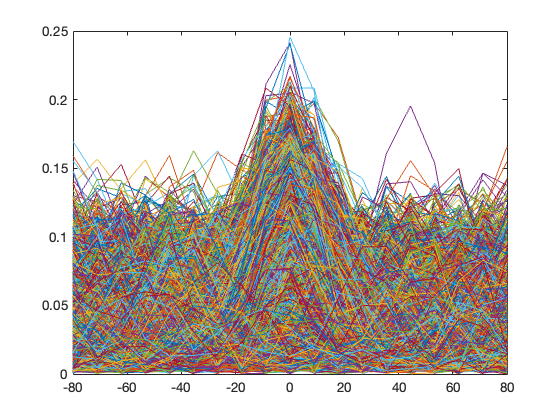

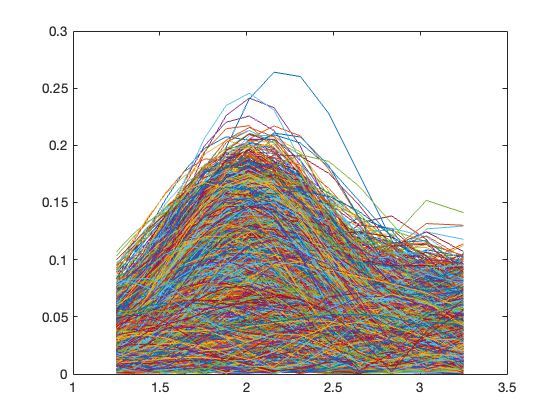

In [10]:
% now we can plot the energy across orientation and spatial frequency for all trials for visualization purposes

% all orientation energy at the target SF ~2cpd for all trials
figure;
plot(oriStep,squeeze(FR(8,:,:))); 

% all SF energy at the target orientation 0 deg-vertical for all trials
figure;
plot(freStep,squeeze(FR(:,10,:))); 


### Step 4: Preprocessing
Because what we care about is how the noise affected responses we want to remove the target from target present trials and we do that by subtracting the mean and making the standard deviation 1. Doing so should make the mean in target absent and present trials 0 and std 1. 

In [11]:
nFre  = length(freStep);
nOri  = length(oriStep);
dX    = FR;

contra = unique(trialsMat(:,9)); %contrast
for ii = 1:length(contra)
    %subtract mean
    dX(:,:,targettype==1 & trialsMat(:,9)==contra(ii)) = dX(:,:,targettype==1 ...
        & trialsMat(:,9)==contra(ii))-mean(dX(:,:,targettype==1 & trialsMat(:,9)==contra(ii)),3);
    dX(:,:,targettype==0 & trialsMat(:,9)==contra(ii)) = dX(:,:,targettype==0 ...
        & trialsMat(:,9)==contra(ii))-mean(dX(:,:,targettype==0 & trialsMat(:,9)==contra(ii)),3);
    %divide by std
    dX(:,:,targettype==1 & trialsMat(:,9)==contra(ii)) = dX(:,:,targettype==1 & trialsMat(:,9)==contra(ii))...
        ./std(dX(:,:,targettype==1 & trialsMat(:,9)==contra(ii)),[],3);
    dX(:,:,targettype==0 & trialsMat(:,9)==contra(ii)) = dX(:,:,targettype==0 & trialsMat(:,9)==contra(ii))...
        ./std(dX(:,:,targettype==0 & trialsMat(:,9)==contra(ii)),[],3);    
end

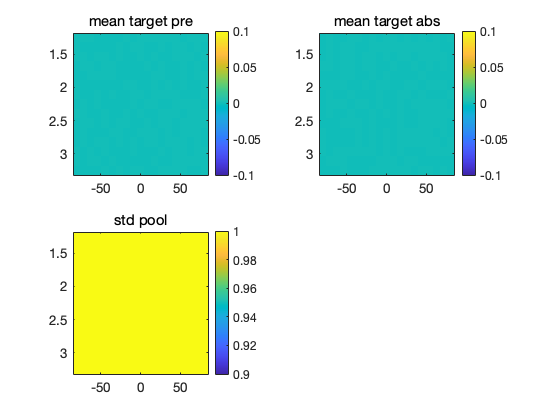

In [12]:
% we can plot this to make sure it worked
figure;
subplot(2,2,1);
imagesc(oriStep,freStep,mean(dX(:,:,targettype==1),3),[min(dX(:)) max(dX(:))]/2); colorbar; caxis([-0.1 0.1]);
title('mean target pre')
subplot(2,2,2);
imagesc(oriStep,freStep,mean(dX(:,:,targettype==0),3),[min(dX(:)) max(dX(:))]/2); colorbar; caxis([-0.1 0.1]);
title('mean target abs')
subplot(2,2,3);
imagesc(oriStep,freStep,std(dX,[],3)); colorbar; caxis([0.9 1]);
title('std pool');


### Step 5: Compute Kernels (i.e., perceptual filters) via binomial regression


In [13]:
%%file binomialglm.m
function [beta,varb] = binomialglm(X,y,condIdx)
%This function does 2d binomial regression (orientation and spatial freq)
%X is your filter response matrix after pre-processing 
%y is the subject response (present or absent)
%condIdx is your condition Index 
%The result B is a vector of coefficient estimates
%Last edit: af 7/14/17

nChan1       = size(X,1);
nChan2       = size(X,2);
nObservation = size(X,3);
assert(nObservation == length(y));

X = X(:,:,condIdx);
y = y(condIdx);
beta = nan(nChan1,nChan2);


for i = 1:nChan1
    for j = 1:nChan2
        tempX = squeeze(X(i,j,:));
        [b,~,stats] = glmfit(tempX,y,'binomial','link','probit');
        beta(i,j) = b(2);
        %calculate variance explained by the model
        varb(i,j) = 1-var(stats.resid)./var(y);
    end
end

Created file '/Users/antonio/binomialglm.m'.


In [14]:
% first we need to index observers responses and cueing conditions (valid, neutral, & invalid)
% importantly regression is done on observers responses and NOT on their accuracy
response = trialsMat(:,7)==1;
condIdx = trialsMat(:,2);

[CI_glm.v,~] = binomialglm(dX,response,condIdx==1); % valid 
[CI_glm.n,~] = binomialglm(dX,response,condIdx==2); % neutral
[CI_glm.i,~] = binomialglm(dX,response,condIdx==3); % invalid

### Step 6: MIRROR or "FOLD" the kernels
To avoid noise, it is common to mirror or fold the kernels over orientation. The assumption is that a negative and positive orientation should be perceptually the same. The way this is done is by taking the mean of each + and - orientation. See below: 


In [15]:
%valid 
lowerHalfOri = floor(length(oriStep)/2); midOri = lowerHalfOri+1;
mirror_l = CI_glm.v(:,1:lowerHalfOri); mirror_m = CI_glm.v(:,midOri); 
mirror_r = flip(CI_glm.v(:,(midOri+1):end),2); 
lenSF = length(freStep);
mirror = zeros(lenSF,lowerHalfOri);
for ii = 1:lowerHalfOri
    for jj = 1:lenSF
        mirror(jj,ii) = mean([mirror_l(jj,ii),mirror_r(jj,ii)]);
    end
end
CI.mirrorValid = [mirror,mirror_m,flip(mirror,2)];

%neutral
mirror_l = CI_glm.n(:,1:lowerHalfOri); mirror_m = CI_glm.n(:,midOri); 
mirror_r = flip(CI_glm.n(:,(midOri+1):end),2); 
mirror = zeros(lenSF,lowerHalfOri);
for ii = 1:lowerHalfOri
    for jj = 1:lenSF
        mirror(jj,ii) = mean([mirror_l(jj,ii),mirror_r(jj,ii)]);
    end
end
CI.mirrorNeutral = [mirror,mirror_m,flip(mirror,2)];

%Invalid
mirror_l = CI_glm.i(:,1:lowerHalfOri); mirror_m = CI_glm.i(:,midOri); 
mirror_r = flip(CI_glm.i(:,(midOri+1):end),2); 
mirror = zeros(lenSF,lowerHalfOri);
for ii = 1:lowerHalfOri
    for jj = 1:lenSF
        mirror(jj,ii) = mean([mirror_l(jj,ii),mirror_r(jj,ii)]);
    end
end
CI.mirrorInvalid = [mirror,mirror_m,flip(mirror,2)];

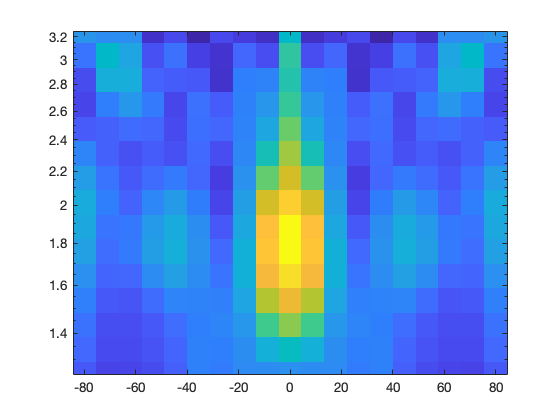

In [16]:
% now we can plot the folded kernels
% i am only going to plot one, but you can plot all three if you like
figure;
imagesc(oriStep,freStep,CI.mirrorNeutral); 
set(gca,'YDir','normal','YScale','log'); 
ylim([1.25,3.25]);

### Step 7: Compute marginals
Now the last step is to just average over both dimensions of the kernel

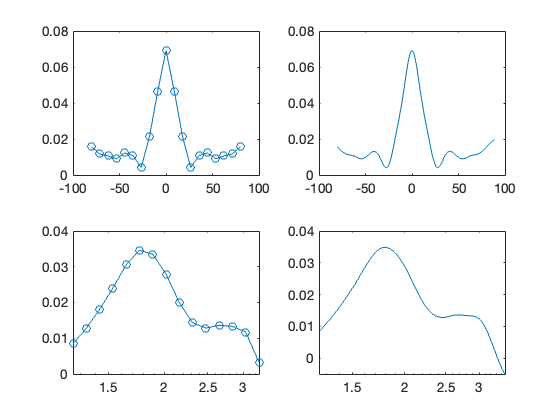

In [20]:
subplot(221);
plot(oriStep,mean(CI.mirrorNeutral),'o-'); 
% can also interpolate to make it look smoother
subplot(222);
plot(interp(oriStep,30),interp(mean(CI.mirrorNeutral),30),'-'); 
% but not necessary as its typical to fit this data with an underlying function (e.g. Gaussian for orientation)
subplot(223);
semilogx(freStep,mean(CI.mirrorNeutral,2),'o-'); 
subplot(224);
semilogx(interp(freStep,30),interp(mean(CI.mirrorNeutral,2),30),'-'); 

### Important:
#### computing the marginals is not necessary. If you have reason to believe the dimensions you are working with are not separable you could fit a 2D function (e.g. gaussian) in which case parameters are shared for both dimensions. To check whether your dimensions are separable you simply try to reconstruct your original kernel from the marginals as so:

In [21]:
ori_marginal = mean(CI.mirrorNeutral)';
sf_marginal  = mean(CI.mirrorNeutral,2)'; %if your marginals have negatives, you will need to take the mean(abs(X)). 
newKernel = ori_marginal*sf_marginal;

% if the new and old kernel are highly correlated then the two dimensions are separable, otherwise no
corr2(CI.mirrorNeutral,newKernel')


ans =

    0.8927



#### assuming your data is seperable the FINAL step is to fit the marginals with a function of your choosing. I assume that you know how to fit data so the demo ends here. However, at some point I will add another demo on data fitting.